# NR band notebook

Erik Hogenbirk, May 2017

### Imports

In [2]:
# General definitions
%run '../definitions.ipynb'
%run '../treemakers.ipynb'

# Specific to this analysis
# %run 'definitions.ipynb'

### Analysis class

In [3]:
%run '../Analysis_class.ipynb'

## New analysis

In [4]:
local_data = True

if local_data:
    processed_data_path_er = '/home/erik/win/data/xams_run8/processed/er/'
    processed_data_path_nr = '/home/erik/win/data/xams_run8/processed/ambe/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    processed_data_path = '/data/xenon/xams/run8/processed/data/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [33]:
run_names_nr = get_run_list(processed_data_path_nr)
run_names_er = get_run_list(processed_data_path_er)

Run list contains 14 files
Run list contains 5 files


In [34]:
x = XAMSAnalysis(run_names_nr[:-1], processed_data_path_nr, minitree_path)

In [35]:
x.load()

Finite s1 selection: 261271 rows removed (74.31% passed)
s1 above 5 selection: 74239 rows removed (90.18% passed)
s2 above 100 selection: 27274 rows removed (96.00% passed)


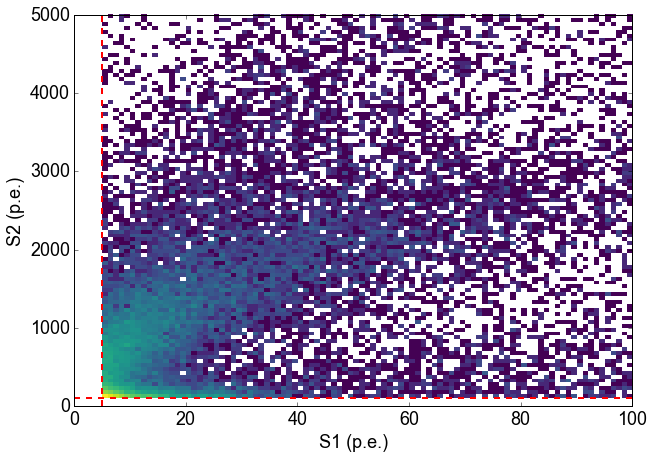

s1 below 300 selection: 579391 rows removed (11.44% passed)
s2 below 20000.0 selection: 26119 rows removed (65.09% passed)


AttributeError: 'dict' object has no attribute 'largest_other_s1_max'

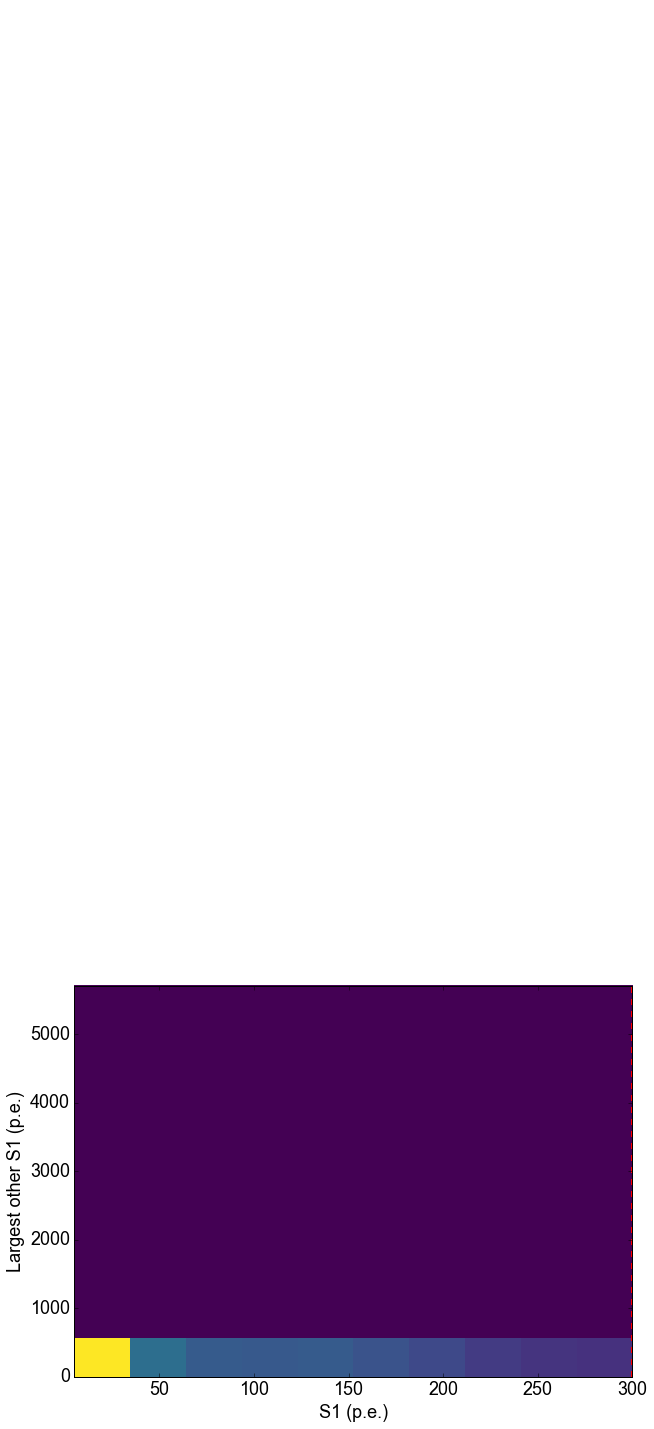

In [30]:
x.cut_interaction_exists()
x.cut_thresholds(5, 100, plot=True, bins=100, norm=LogNorm(), range=((0, 100), (0, 5000)))
x.cut_low_energy(300, 20e3, plot=True, bins=100, norm=LogNorm())
x.cut_largest_other_s1(plot=True)

In [18]:
x.cuts_apply_all()

Finite s1 selection: 261271 rows removed (74.31% passed)
s1 above 5.0 selection: 0 rows removed (100.00% passed)
s2 above 100.0 selection: 0 rows removed (100.00% passed)
s1 below 1000 selection: 286525 rows removed (56.20% passed)
s2 below 60000.0 selection: 210681 rows removed (42.70% passed)
{'largest_other_s1_max': 5.0}
largest_other_s1 below 5.0 selection: 16172 rows removed (89.70% passed)
largest_other_s2 below 100.0 selection: 15161 rows removed (89.23% passed)
s1_n_saturated_channels below 1 selection: 0 rows removed (100.00% passed)
s2_n_saturated_channels below 1 selection: 8653 rows removed (93.11% passed)
s2_area_fraction_top in [0.55, 0.78) selection: 297 rows removed (99.75% passed)
AFT_Upper selection: 4319 rows removed (96.30% passed)
AFT_Lower selection: 4887 rows removed (95.65% passed)
drift_time in [0, 60) selection: 2747 rows removed (97.45% passed)


In [253]:
x.corr_s1_ly()

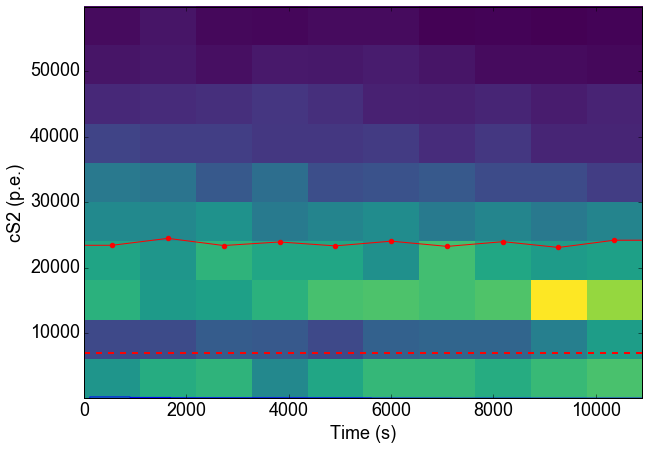

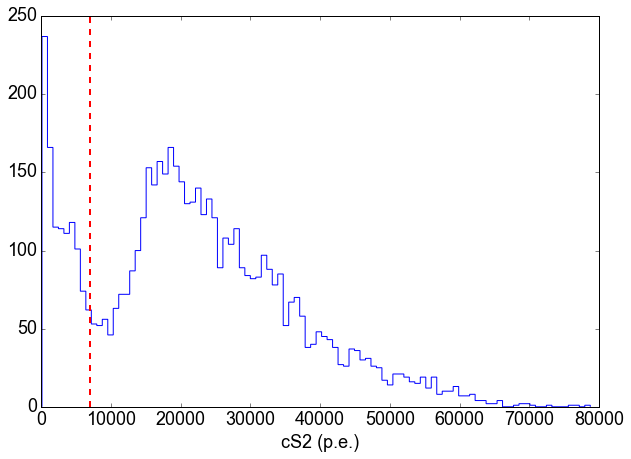

In [256]:
x.corr_s2_sag((200, 250), bins=10, plot=True)

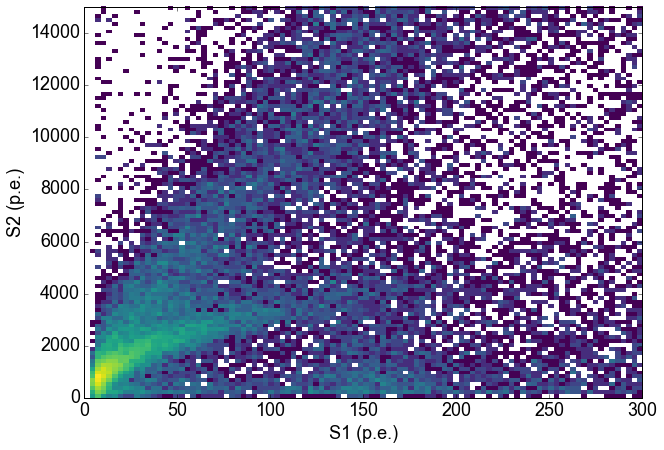

In [257]:
x.plot_cs1cs2(bins=100, norm=LogNorm(), range=((0, 300), (0, 15000)))

## OLD ANALYSIS

### Read data

In [198]:
# Compute the difference from the trend
d_nr['s1_aft_difference'] = d_nr['s1_area_fraction_top'] - f_s1_aft(d_nr['drift_time'])

# Get the upper and lower percentiles...
x, y_upper = get_trend(d_nr['s1'], d_nr['s1_aft_difference'], bins=20, x_range=(0, 400), mode='percentile', pct=95)
x, y_lower = get_trend(d_nr['s1'], d_nr['s1_aft_difference'], bins=20, x_range=(0, 400), mode='percentile',pct=5)

# ... And their interpolation...
f_lower = my_interp(x, y_lower, kind='cubic')
f_upper = my_interp(x, y_upper, kind='cubic')

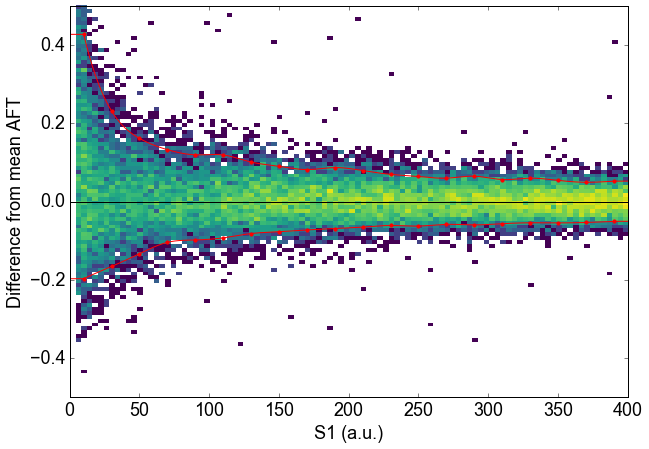

In [199]:
plt.hist2d(d_nr['s1'], d_nr['s1_aft_difference'], bins=100, range=((0, 400), (-0.5, 0.5)), norm=LogNorm())
plt.axhline(0, color='black')
x_plot = np.linspace(0, 400, 400)

plt.plot(x_plot, f_upper(x_plot), color='red', label='Interpolation')
plt.plot(x_plot, f_lower(x_plot), color='red')
plt.scatter(x, y_upper, s=10, color='red', label='Binned percentile')
plt.scatter(x, y_lower, s=10, color='red')
plt.xlabel('S1 (a.u.)')
plt.ylabel('Difference from mean AFT')
plt.show()

In [200]:
d_nr['AFT_Upper'] = (d_nr['s1_aft_difference'] < f_upper(d_nr['s1'])) # Add boolean variable
d_nr['AFT_Lower'] = (d_nr['s1_aft_difference'] > f_lower(d_nr['s1']))
d_nr = cuts.selection(d_nr, d_nr['AFT_Upper'], 'AFT_Upper')
d_nr = cuts.selection(d_nr, d_nr['AFT_Lower'], 'AFT_Lower')

AFT_Upper selection: 1547 rows removed (96.09% passed)
AFT_Lower selection: 1761 rows removed (95.37% passed)


### Drift time

In [201]:
d_er = cuts.range_selection(d_er, 'drift_time', (0, 60))
d_nr = cuts.range_selection(d_nr, 'drift_time', (0, 60))

drift_time in [0, 60) selection: 312 rows removed (98.79% passed)
drift_time in [0, 60) selection: 810 rows removed (97.77% passed)


## What have we got

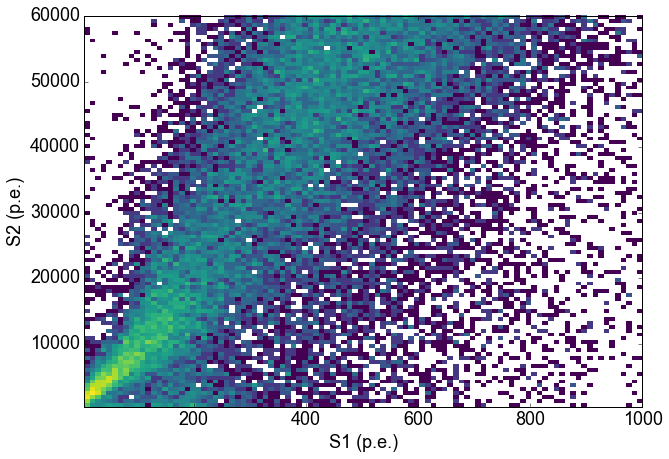

In [202]:
plt_s1s2(d_er['s1'], d_er['s2'], bins=100, norm=LogNorm())

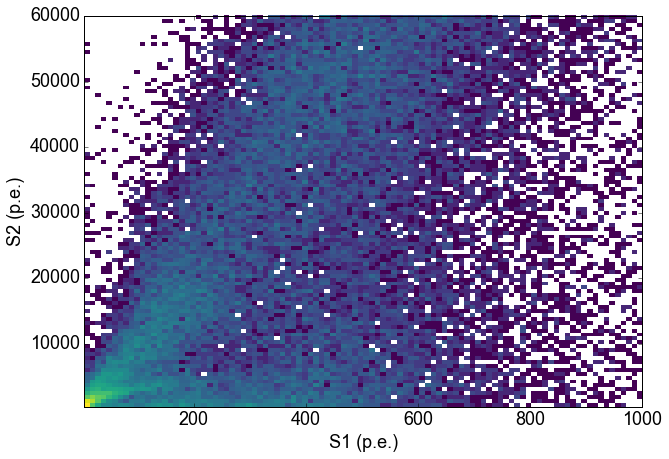

In [203]:
plt_s1s2(d_nr['s1'], d_nr['s2'], bins=100, norm=LogNorm())

## Corrections

In [204]:
# Import the correction from Cs calibration
import pickle
# Interpolate light curve
x_cs, y_cs = pickle.load(open('../light_yield/xy_cs', 'rb'))
f_s1_corr_cs = my_interp(x_cs, y_cs)

def get_cs1(s1, z, f_s1_corr):
    average_s1 = np.average([f_s1_corr(_z) for _z in np.linspace(-10, 0, 100)])
    return s1/f_s1_corr(z) * average_s1

d_er['cs1']= get_cs1(d_er['s1'], d_er['z'], f_s1_corr_cs)
d_nr['cs1']= get_cs1(d_nr['s1'], d_nr['z'], f_s1_corr_cs)

### Compare

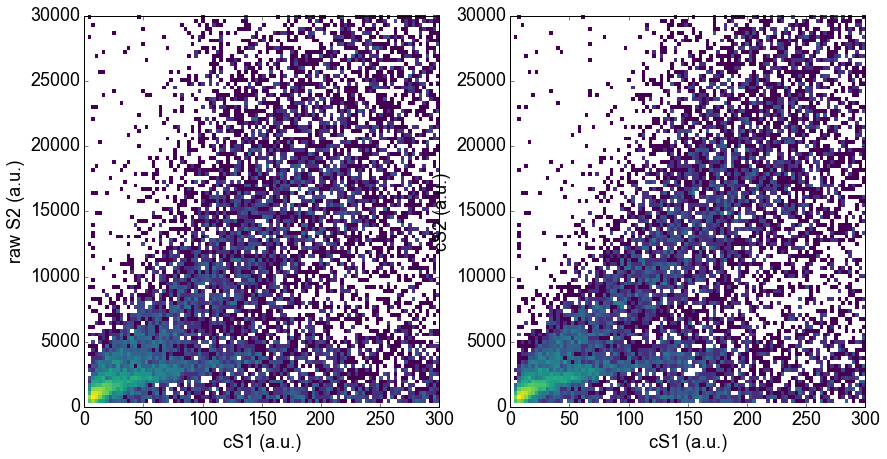

In [210]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.hist2d(d_nr['s1'], d_nr['s2'], bins=100, norm=LogNorm(), range=((0, 300), (0, 30e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')

plt.subplot(122)
plt.hist2d(d_nr['cs1'], d_nr['s2'], bins=100, norm=LogNorm(), range=((0, 300), (0, 30e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('cS2 (a.u.)')


plt.show()

In [228]:
d_nr['t'] = (d_nr['event_time'] - d_nr['event_time'].values[0]) * 1e-9
d_er['t'] = (d_er['event_time'] - d_er['event_time'].values[0]) * 1e-9

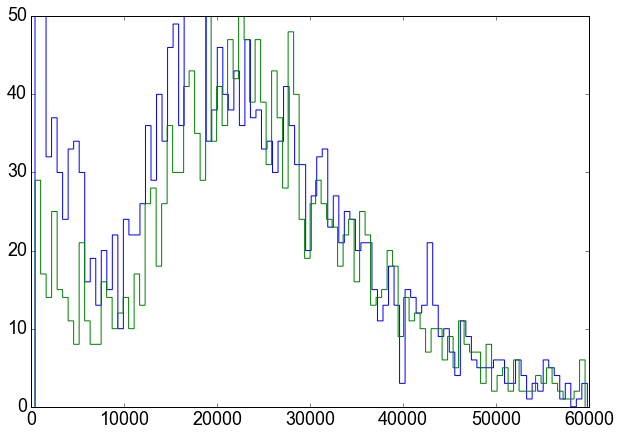

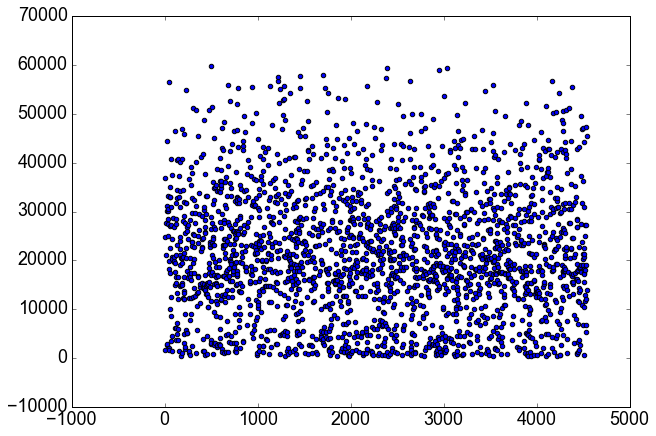

In [231]:
edges = (200, 250)
_d = d_nr[(d_nr['cs1'] > edges[0]) & (d_nr['cs1'] < edges[1])]
_d2 = d_er[(d_er['cs1'] > edges[0]) & (d_er['cs1'] < edges[1])]


plt.hist(_d['s2'], bins=100, histtype='step')
plt.hist(_d2['s2'], bins=100, histtype='step')
plt.show()

plt.scatter(_d['t'], _d['s2'])
plt.show()

### Too low S2 population?

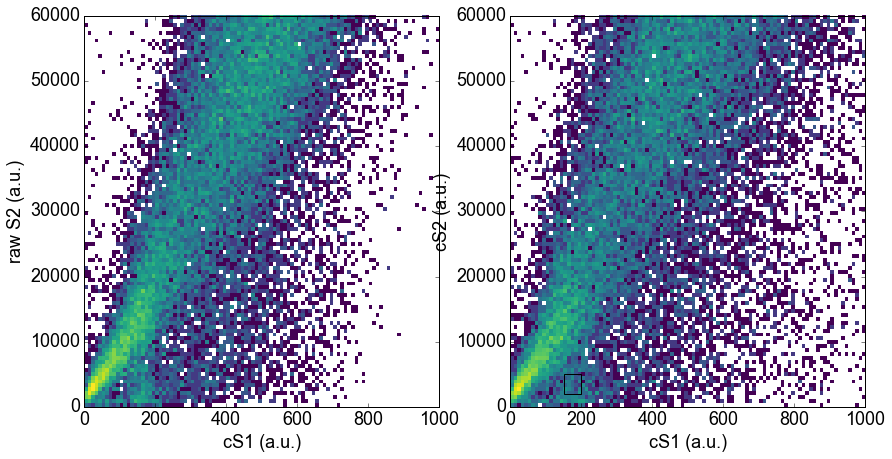

In [85]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.hist2d(d_er['cs1'], d_er['s2'], bins=100, norm=LogNorm(), range=((0, 1000), (0, 60e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('raw S2 (a.u.)')

plt.subplot(122)
plt.hist2d(d_er['s1'], d_er['s2'], bins=100, norm=LogNorm(), range=((0, 1000), (0, 60e3)))
plt.xlabel('cS1 (a.u.)')
plt.ylabel('cS2 (a.u.)')
draw_box((150, 200), (2000, 5000))


plt.show()

In [89]:
manna = (d_er['cs1'] > 150) & (d_er['cs1'] < 200) & (d_er['cs2'] > 2000) & (d_er['cs2'] < 5000)
d_er[manna][['event_number', 's1', 's2', 'drift_time']].head()

,event_number,s1,s2,drift_time
540,540,267.519073,2695.479004,59.812
3766,3766,143.459549,2253.384033,29.104
6215,6215,157.592896,3560.199463,31.060
9342,9342,156.807739,4784.829590,13.382
10338,10338,127.519852,3984.224365,16.526


In [94]:
d_er.keys()

Index(['run_number', 'event_number', 's1_n_saturated_channels',
       's2_n_saturated_channels', 'cs1', 'cs2', 'drift_time',
       'largest_coincidence', 'largest_other_s1', 'largest_other_s2',
       'largest_unknown', 'largest_veto', 's1', 's1_area_fraction_top',
       's1_range_50p_area', 's2', 's2_area_fraction_top', 's2_range_50p_area',
       'x', 'y', 'z', 'event_duration', 'event_time', 's1_aft_difference',
       'AFT_Upper', 'AFT_Lower'],
      dtype='object')

(0, 10000)

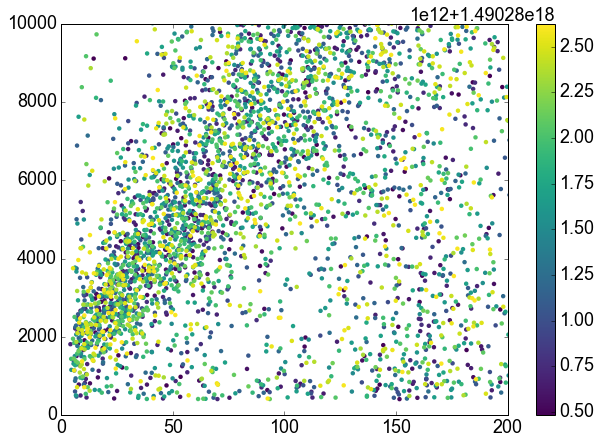

In [218]:
plt.scatter(d_er['cs1'], d_er['s2'], edgecolor='None', c=d_er['event_time'])
plt.colorbar()
plt.xlim(0, 200)
plt.ylim(0, 10000)

### Position

In [145]:
z_bounds = (-9, -1)

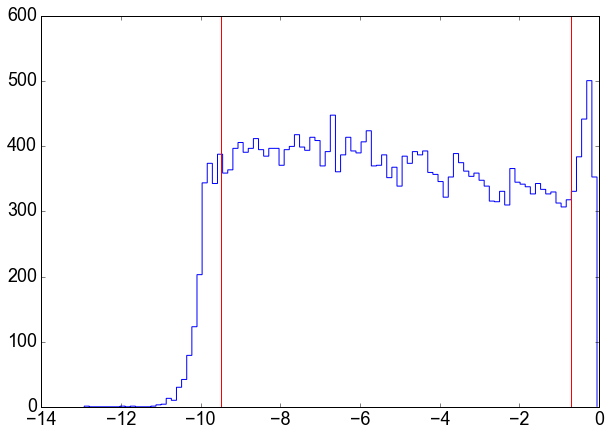

In [146]:
plt.hist(d_er['z'], histtype='step', bins=100)
for _l in z_bounds:
    plt.axvline(_l, color='red')
plt.show()

### S2 width

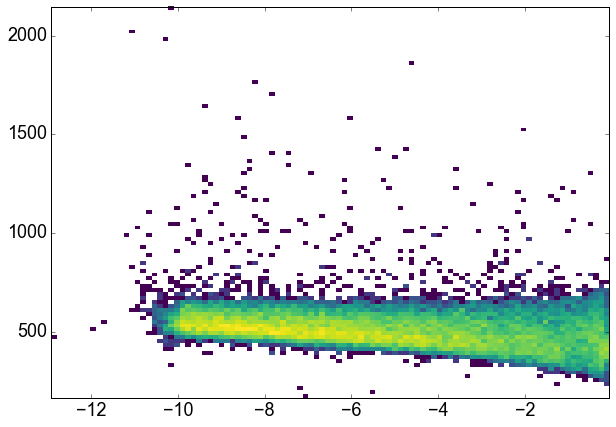

In [147]:
plt.hist2d(d_er['z'], d_er['s2_range_50p_area'], bins=100, norm=LogNorm())
plt.show()

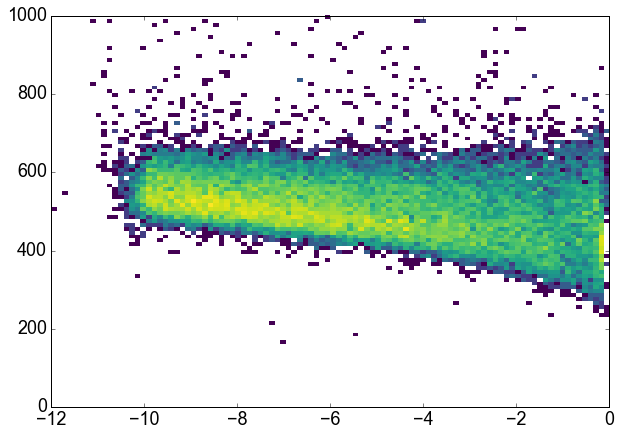

In [148]:
plt.hist2d(d_er['z'], d_er['s2_range_50p_area'], bins=100, norm=LogNorm(), range=((-12, 0), (0, 1000)))
plt.show()

In [149]:
from pax import units, configuration
PAX_CONFIG = configuration.load_configuration('XENON1T')

In [150]:
def s2_width_model(z):
    diffusion_constant = PAX_CONFIG['WaveformSimulator']['diffusion_constant_liquid']
    v_drift = 1.68 * units.km/units.s

    w0 = 348.6 * units.ns
    return np.sqrt(w0 ** 2 - 4.0325 * diffusion_constant * z / v_drift ** 3)

In [151]:
s2_range_fraction = (0.8, 1.2)

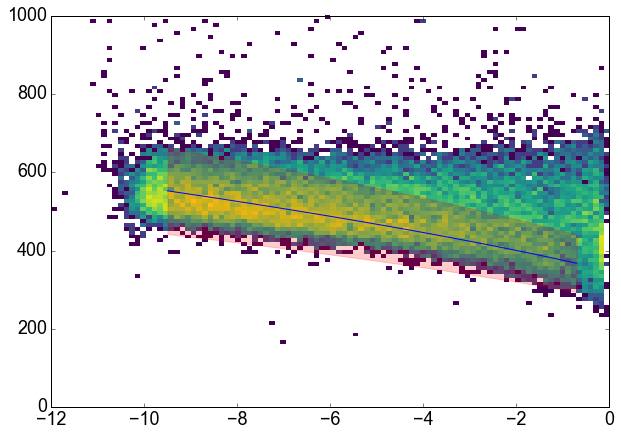

In [152]:
plt.hist2d(d_er['z'], d_er['s2_range_50p_area'], bins=100, norm=LogNorm(), range=((-12, 0), (0, 1000)))
x_plt = np.linspace(z_bounds[0], z_bounds[1], 100)
plt.plot(x_plt, s2_width_model(x_plt))

plt.fill_between(x_plt, s2_range_fraction[0] * s2_width_model(x_plt), s2_range_fraction[1] * s2_width_model(x_plt),
                color='red', alpha=0.2)

plt.show()

In [153]:
d_er = cuts.range_selection(d_er, 'z', z_bounds)

z in [-9.5, -0.7) selection: 3829 rows removed (86.84% passed)


In [154]:
d_er = cuts.selection(d_er, (
        (d_er['s2_range_50p_area'] > s2_range_fraction[0] * s2_width_model(d_er['z'])) &
        (d_er['s2_range_50p_area'] < s2_range_fraction[1] * s2_width_model(d_er['z']))),
                      'S2 width cut')

S2 width cut selection: 5528 rows removed (78.13% passed)


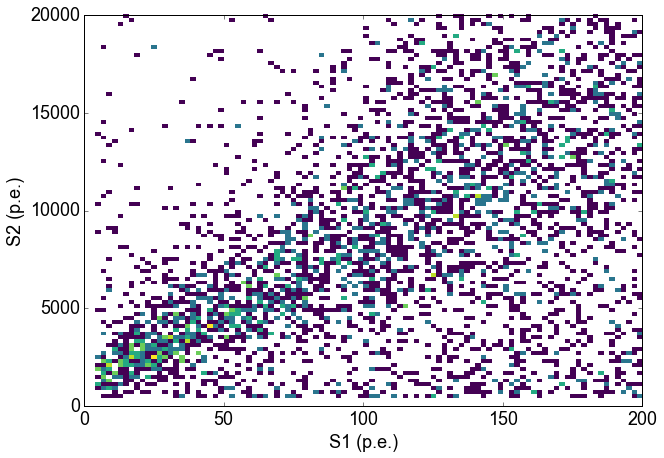

In [162]:
plt_s1s2(d_er['s1'], d_er['s2'], bins=(100,100), range=((0, 200), (0, 20e3)), norm=LogNorm())

plt.show()

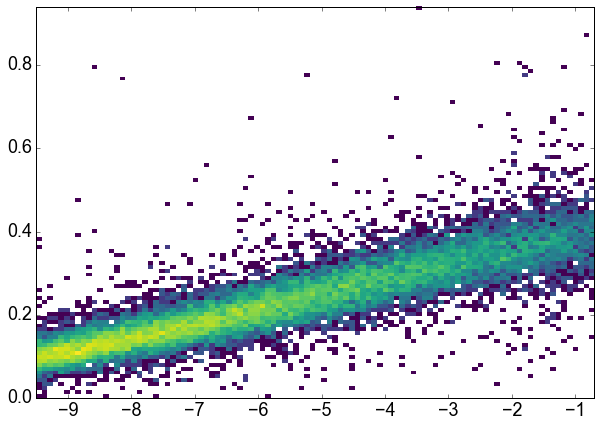

In [161]:
plt.hist2d(d_er['z'], d_er['s1_area_fraction_top'], bins=100, norm=LogNorm())
plt.show()